For Mariah, I am estimating the closeness of two human proteins, 

I will do so by comparing the number of paths of l=1,...,4 length, to the average number, estimated from a handful of random pairs.

Mariah: use homo sapiens with ENSP00000229239 and ENSP00000405573.
Remi wants: YBL093C, ROX3. YJR066W, TOR1

In [1]:
"""Imports and arguments"""

import csv

import networkx as nx

import numpy as np
import scipy as sp
import numpy.linalg as lin
import numpy.random as rand
import matplotlib.pyplot as plt
import network_utilities as nu
import networkx.algorithms.community as nx_comm
import tensorflow as tf

# some basic settings for plotting figures
%matplotlib inline 
font = {'family' : 'serif',
        'weight' : 'light',
        'size'   : 20}

plt.rc('font', **font)

extra_outputs = False;

In [2]:
"""Loading data"""

# This is the variable that will store the protein names. 
ess_list = []; 

with open('essential_proteins.csv', newline='') as ess_file:
    reader = csv.reader(ess_file)
    ess_data = list(reader)

for i in range(len(ess_data)):
    ess_list.append(ess_data[i][1])
    
# Read in the string-db for Yeast
G0 = nx.read_weighted_edgelist("./yeast_protein_edgelist_trimmed.txt",comments="#",nodetype=str)

# For interest, plot the distribution of confidence scores
if (extra_outputs):
    plt.figure(figsize=(6,6));
    full_edges = G0.edges()
    these_weights = [G0[u][v]['weight'] for u,v in full_edges]

    plt.hist(these_weights, bins=40);
    plt.title("Confidence score distribution")
    plt.xlabel("Confidence score")
    plt.ylabel("# Edges")
    plt.show();
    
# delete those edges with a combined score of <= threshold_score (small confidence)
threshold_score = 700;
for edge in G0.edges: 
    weight = list(G0.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] <= threshold_score):
        G0.remove_edge(edge[0],edge[1])
        
# Take only the largest connected subgraph
largest_cc = max(nx.connected_components(G0),key=len)
G = G0.subgraph(largest_cc);
print(G)

Graph with 5932 nodes and 119977 edges


First we look at the geodesic distance:

This is the output of Elden's code, looking for paths between proteins YBL093C and YJR066W

The proteins are 3 steps apart

There are 69 paths of length 3 . They are:
['YBL093C', 'YOL051W', 'YEL009C', 'YJR066W']
['YBL093C', 'YDL140C', 'YEL009C', 'YJR066W']
['YBL093C', 'YDR308C', 'YEL009C', 'YJR066W']
['YBL093C', 'YML007W', 'YEL009C', 'YJR066W']
['YBL093C', 'YOR140W', 'YEL009C', 'YJR066W']
['YBL093C', 'YPL042C', 'YEL009C', 'YJR066W']
['YBL093C', 'YPR086W', 'YEL009C', 'YJR066W']
['YBL093C', 'YGL025C', 'YEL009C', 'YJR066W']
['YBL093C', 'YER148W', 'YEL009C', 'YJR066W']
['YBL093C', 'YHR041C', 'YEL009C', 'YJR066W']
['YBL093C', 'YOL051W', 'YGR252W', 'YJR066W']
['YBL093C', 'YPL129W', 'YGR252W', 'YJR066W']
['YBL093C', 'YDL140C', 'YGR252W', 'YJR066W']
['YBL093C', 'YKL058W', 'YGR252W', 'YJR066W']
['YBL093C', 'YNL236W', 'YGR252W', 'YJR066W']
['YBL093C', 'YPL042C', 'YGR252W', 'YJR066W']
['YBL093C', 'YPR086W', 'YGR252W', 'YJR066W']
['YBL093C', 'YER148W', 'YGR252W', 'YJR066W']
['YBL093C', 'YOR194C', 

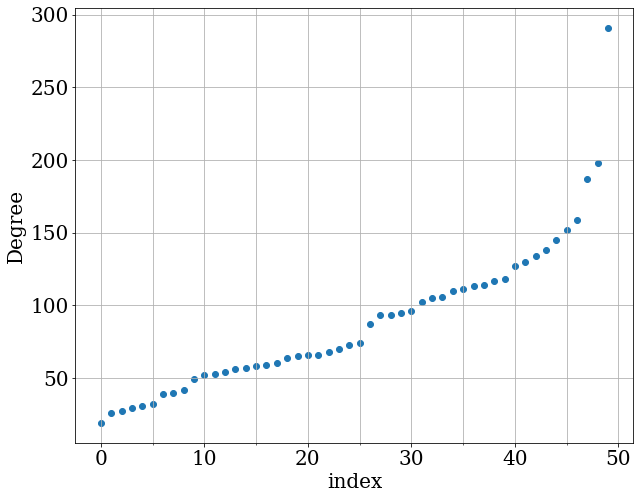

In [62]:
p1 = "YBL093C"
p2 = "YJR066W"

degree_dict = G.degree

pp_distance = nx.shortest_path_length(G,p1,p2)

print("This is the output of Elden's code, looking for paths between proteins", p1, "and", p2)
print("")
print("The proteins are",pp_distance,"steps apart")
print("")

all_geodesic_paths = list(nx.all_shortest_paths(G,p1,p2,weight=None));
unique_elements = sorted(list(set(np.ravel(all_geodesic_paths))), key=lambda n:degree_dict[n]) #uniqueness
path_degrees = [degree_dict[n] for n in unique_elements]

print("There are", len(all_geodesic_paths), "paths of length",pp_distance,". They are:")
for path in all_geodesic_paths:
    print(path)
print("")
print("There are", len(unique_elements), "unique proteins among these paths. They are (ordered "
      + "from lowest to highest degree; roughly representing 'importance'):")

for i in range(len(unique_elements)):
    print(i,":",unique_elements[i])
    
plt.figure(figsize=(10,8))
plt.scatter(range(len(unique_elements)),path_degrees)
plt.ylabel("Degree")
plt.xlabel("index");

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
plt.gca().xaxis.set_minor_locator(MultipleLocator(5))
plt.grid(axis = 'both', which='both');

Clearly this is unsatisfying. Let's examine the longer paths as well

In [5]:
p1i = list(G.nodes).index(p1)
p2i = list(G.nodes).index(p2)

A = nx.to_numpy_array(G, weight=None) # We have to get rid of the weights.
print(A[p1i,p2i])

# Then the powers of A are:

def An(n):
    return lin.matrix_power(A,n)

0.0


Take T random pairs of proteins, and calculate the number of paths of length l=1,2,...,L between them. Record the average
for each length, then compare to the same distribution for our two proteins of interest.

In [6]:
L = 4

N = len(list(G.nodes));

A_pows = [A] 
for l in range(0,L):
    print("Calculating power",l+1,"...")
    A_pows.append(np.matmul(A_pows[l],A))

print("Done!")
# precalculate the powers of A. This is sloooow

Calculating power 1 ...
Calculating power 2 ...
Calculating power 3 ...
Calculating power 4 ...
Done!


In [7]:
rand_Nls = list(np.zeros(L));
T = 10000
for t in range(T):
    pr1, pr2 = rand.choice(range(N), size=2, replace=False)
    for n in range(L):
        rand_Nls[n] += A_pows[n][pr1,pr2]
        #print("Done trial t =",t,"of",T,"at length l =",n,"of",L)

rand_Nls = [Nl/T for Nl in rand_Nls] # divide by the number of trials to get the mean
print(rand_Nls)

[0.0083, 0.9234, 160.0648, 31581.7518]


In [8]:
pp_Nls = list(np.zeros(L));
for n in range(L):
        pp_Nls[n] += A_pows[n][p1i,p2i]
print(pp_Nls)

[0.0, 0.0, 69.0, 6007.0]


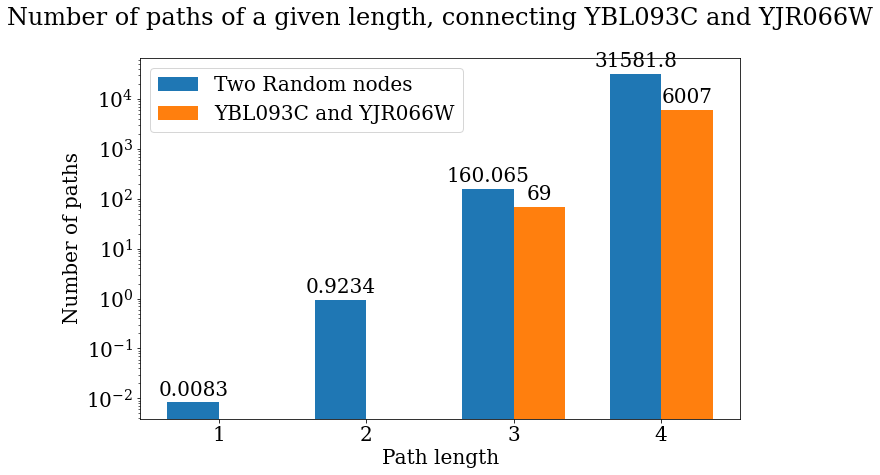

In [64]:
ls = range(1,L+1)

x = np.arange(len(ls))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,7))
rects1 = ax.bar(x - width/2, rand_Nls, width, label='Two Random nodes')
rects2 = ax.bar(x + width/2, pp_Nls, width, label=str(p1) + " and " + str(p2))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of paths')
ax.set_xlabel("Path length")
ax.set_title("Number of paths of a given length, connecting " + str(p1) + " and " + str(p2)+"\n")
ax.set_xticks(x, ls)
ax.legend()
plt.yscale("log")

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [53]:
nodelist = list(G.nodes);

for t in range(10):
    pr1, pr2 = rand.choice(nodelist, size=2, replace=False)
    print(nx.shortest_path_length(G,pr1,pr2))

4
3
3
3
5
2
3
3
4
4
